In [2]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode

In [115]:
def process_video_data(features_path, labels_data):
    features_list = []
    labels_list = []
    urls_list = []
    empty_frame_count = 0
    empty_frame_ids = []

    for video_file in glob.glob(os.path.join(features_path, "*.npy")):
        video_id = os.path.basename(video_file).split("_")[0]
        feature_array = np.load(video_file)

        if feature_array.size == 0:
            empty_frame_count += 1
            empty_frame_ids.append(video_id)
            continue

        avg_feature = np.mean(feature_array, axis=0)
        features_list.append(avg_feature)

        label = labels_data[labels_data["youtube_id"] == video_id]["label"].values[0]
        labels_list.append(label)

        url = labels_data[labels_data["youtube_id"] == video_id]["youtube_id"].values[0]
        urls_list.append(url)

    print(f"Number of empty videos not included ({features_path}): {empty_frame_count}")
    print(f"Labels of empty videos not included: {empty_frame_ids}")

    stacked_features = np.vstack(features_list)
    stacked_labels = np.vstack(labels_list)
    stacked_urls = np.vstack(urls_list)

    features_df = pd.DataFrame(stacked_features)
    labels_df = pd.DataFrame(stacked_labels)
    urls_df = pd.DataFrame(stacked_urls, columns=["youtube_id"])

    return urls_df, features_df, labels_df

In [117]:

df_train_labels = pd.read_csv(
    "./url_data/train_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_val_labels = pd.read_csv(
    "./url_data/val_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_test_labels = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_train_labels.drop(index=df_train_labels.index[0], axis=0, inplace=True)
df_val_labels.drop(index=df_val_labels.index[0], axis=0, inplace=True)
df_test_labels.drop(index=df_test_labels.index[0], axis=0, inplace=True)

df_test_labels.head()

,youtube_id,label
1,oaVWnxlQOeo,NaN
2,7zMBk9Zu9fY,NaN
3,DwPEZeX5WkA,NaN
4,bO1MW9Lq9Sg,NaN
5,TdBpD9Ccg9w,NaN


In [137]:
models_r21d = ["r2plus1d_18_16_kinetics","r2plus1d_34_32_ig65m_ft_kinetics","r2plus1d_34_8_ig65m_ft_kinetics"]
for path in models_r21d:
    
    # train
    print("train")
    urls_train, X_train, Y_train = process_video_data(
    f"./numpy_data/train/r21d/{path}/", df_train_labels)
    urls_train.dropna(inplace=True)
    X_train.dropna(inplace=True)
    Y_train.dropna(inplace=True)
    train_data_extracted_df = pd.concat([urls_train, X_train, Y_train], axis=1)
    # Exportar a un archivo CSV
    train_data_extracted_df.to_csv(f'./csv_data/train_data_{path}.csv', index=False)
    print("")
    # val
    print("val")
    urls_val, X_val, Y_val = process_video_data(
    f"./numpy_data/val/r21d/{path}/", df_val_labels)
    urls_val.dropna(inplace=True)
    X_val.dropna(inplace=True)
    Y_val.dropna(inplace=True)
    val_data_extracted_df = pd.concat([urls_val, X_val, Y_val], axis=1)
    # Exportar a un archivo CSV
    val_data_extracted_df.to_csv(f'./csv_data/val_data_{path}.csv', index=False)
    print("")
    # test
    print("test")
    urls_test, X_test, Y_test = process_video_data(
    f"./numpy_data/test/r21d/{path}/", df_test_labels)
    urls_test.dropna(inplace=True)
    X_test.dropna(inplace=True)
    Y_test.dropna(inplace=True)
    test_data_extracted_df = pd.concat([urls_test, X_test, Y_test], axis=1)
    # Exportar a un archivo CSV
    test_data_extracted_df.to_csv(f'./csv_data/test_data_{path}.csv', index=False)
    print("")

train
Number of empty videos not included (./numpy_data/train/r21d/r2plus1d_18_16_kinetics/): 1
Labels of empty videos not included: ['W6TspTTHpzA']

val
Number of empty videos not included (./numpy_data/val/r21d/r2plus1d_18_16_kinetics/): 0
Labels of empty videos not included: []

test
Number of empty videos not included (./numpy_data/test/r21d/r2plus1d_18_16_kinetics/): 0
Labels of empty videos not included: []

train
Number of empty videos not included (./numpy_data/train/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 6
Labels of empty videos not included: ['EQULJzMzmeM', 'W6TspTTHpzA', '-reNwipPPdQ', 'oRwkPwoFIL8', 'yqJXWU8BXEQ', 'B3L0x-AsCZ4']

val
Number of empty videos not included (./numpy_data/val/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

test
Number of empty videos not included (./numpy_data/test/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 1
Labels of empty videos not included: ['se3ihwZ56Uw']

train
Number of empty videos not included (./nump

In [143]:
urls_train, X_train, Y_train = process_video_data(
    f"./numpy_data/train/r21d/{models_r21d[2]}/", df_train_labels
)

urls_train.dropna(inplace=True)
X_train.dropna(inplace=True)
Y_train.dropna(inplace=True)

print(f"\nNúmero de videos cargados para entrenamiento: {len(X_train)}")
print(f"Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}")


Number of empty videos not included (./numpy_data/train/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para entrenamiento: 5415
Shape de nuestra matriz de videos para entrenamiento: (5415, 512)


In [121]:
urls_val, X_val, Y_val = process_video_data(
    f"./numpy_data/val/r21d/{models_r21d[2]}/", df_val_labels
)

urls_val.dropna(inplace=True)
X_val.dropna(inplace=True)
Y_val.dropna(inplace=True)

print(f"\nNúmero de videos cargados para validación: {len(X_val)}")
print(f"Shape de nuestra matriz de videos para validación: {X_val.shape}")


Number of empty videos not included (./numpy_data/val/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para validación: 426
Shape de nuestra matriz de videos para validación: (426, 512)


,youtube_id,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,0
0,JQ6sX-uG9yY,1.496823,0.993600,0.288819,0.063309,0.148164,0.232999,1.070735,0.058242,0.650740,...,1.249280,1.249955,0.082794,1.150549,0.774377,0.663797,0.891119,1.105715,0.870344,fixing hair
1,rjJATi6UX3U,0.276959,0.281776,1.333592,2.151798,0.440352,2.041285,0.184108,0.431927,0.034321,...,1.894569,0.852125,0.088804,0.472972,0.455699,0.963272,0.173772,1.045749,1.532992,riding camel
2,fUcxKEv63PE,0.711488,0.375703,1.651217,0.524740,0.907985,0.098082,0.716112,0.797550,0.671884,...,2.919281,0.411328,1.611390,0.628181,0.884741,1.119184,1.095255,2.149693,0.463938,spraying
3,Cc8VMMrVrxg,2.729330,1.312930,1.299585,1.116935,0.253497,0.258085,0.218476,0.839411,0.749796,...,0.138800,0.062923,0.374575,0.198716,1.227204,1.152009,0.423414,0.570342,0.426691,flipping pancake
4,M1467K7OXiw,0.476338,1.724909,0.283999,0.075915,0.449547,0.387104,0.102456,0.014213,0.248259,...,0.592421,0.121428,0.244837,0.590045,1.131897,0.641699,1.387958,1.490231,1.628770,dying hair


In [123]:
urls_test, X_test, Y_test = process_video_data(
    "./numpy_data/test/r21d/r2plus1d_34_8_ig65m_ft_kinetics/", df_test_labels
)
urls_test.dropna(inplace=True)
X_test.dropna(inplace=True)
Y_test.dropna(inplace=True)

print(f"\nNúmero de videos cargados para testeo: {len(X_test)}")
print(f"Shape de nuestra matriz de videos para testeo: {X_test.shape}")

# Concatenar DataFrames a lo largo de las columnas
test_data_extracted_df = pd.concat([urls_test, X_test], axis=1)

# Exportar a un archivo CSV
test_data_extracted_df.to_csv('./csv_data/test_data_extracted.csv', index=False)
test_data_extracted_df.head()

Number of empty videos not included (./numpy_data/test/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para testeo: 805
Shape de nuestra matriz de videos para testeo: (805, 512)


,youtube_id,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,mpFAMP2Fx-Y,0.553434,0.036327,1.525691,3.023648,0.043020,2.384682,0.105183,0.068101,0.080297,...,1.880497,2.077761,1.328577,0.077194,0.061235,0.396114,1.285335,0.052032,0.922044,1.983737
1,j9d7pFjTYd8,0.084711,1.069156,0.259784,2.592410,2.161556,0.590817,0.189109,1.531570,0.178279,...,1.411450,0.380090,0.818880,0.573951,0.200256,0.225598,1.138147,0.803438,0.976265,1.627621
2,LUsx9ElLHXY,3.316955,2.163343,1.510833,0.547846,1.190354,0.844889,0.004451,0.422373,1.495746,...,2.130009,0.360552,0.237879,0.187588,0.096858,1.641045,1.036371,0.581926,0.634720,0.510954
3,gNQyjpfDBoA,0.716348,0.510593,0.706163,2.944135,0.068518,2.089520,0.770862,0.523187,0.006070,...,1.355871,2.121172,0.610081,0.189378,0.106648,0.243583,1.163544,0.766129,1.490743,1.787828
4,IX9sPL5IRP8,0.243564,0.446337,0.116349,2.802735,1.246715,0.044675,1.359586,1.489012,0.735972,...,0.417960,0.546243,0.750498,0.353692,0.250461,0.259160,0.137497,0.631396,1.290751,1.632087


(5415, 100)


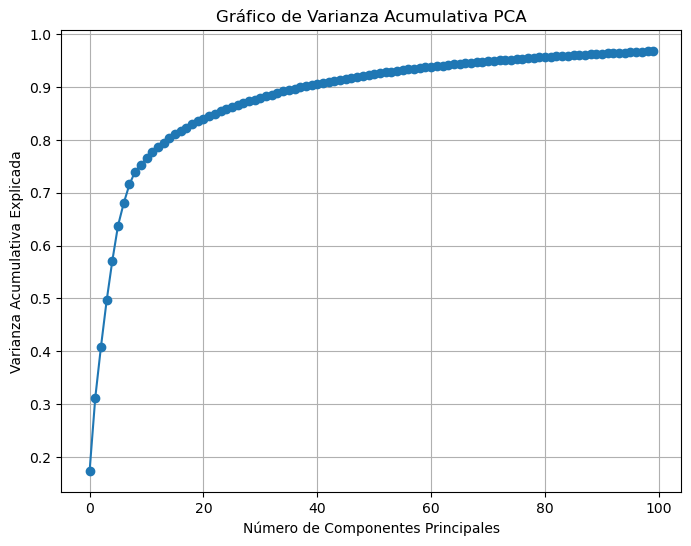

Number of unique values in Y_train: 10
{0: 'fixing hair', 1: 'baking cookies', 2: 'shot put', 3: 'dying hair', 4: 'stretching leg', 5: 'wrapping present', 6: 'riding camel', 7: 'balloon blowing', 8: 'spraying', 9: 'stretching leg'}


In [127]:
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X_train)
print(X_reduced.shape)

explained_variance = pca.explained_variance_ratio_
# Assuming 'explained_variance' is already defined
cumulative_variance = np.cumsum(explained_variance)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100), cumulative_variance[:100], marker='o', linestyle='-')
plt.title('Gráfico de Varianza Acumulativa PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.grid(True)
plt.show()

unique_values = np.unique(Y_train)
num_unique_values = len(unique_values)
print("Number of unique values in Y_train:", num_unique_values)

kmeans = KMeans(n_clusters=num_unique_values, random_state=0, n_init="auto").fit(X_reduced)

labels = kmeans.labels_
# Comparar las etiquetas de KMeans con Y_train
# Aquí asumimos que Y_train es un array de etiquetas reales
# Puedes usar cualquier método de comparación que sea relevante para tu caso

real_labels = np.array(Y_train)
#for i in range(len(Y_train)):
    #print("KMeans label:", kmeans_labels[i], " - Real label:", real_labels[i])

# Encontrar el valor más común de Y_train para cada grupo
cluster_to_y_value = {}
for cluster in np.unique(labels):
    indices = np.where(labels == cluster)[0]
    unique_values, counts = np.unique(real_labels[indices], return_counts=True)
    mode_index = np.argmax(counts)
    mode_value = unique_values[mode_index]
    cluster_to_y_value[cluster] = mode_value

print(cluster_to_y_value)





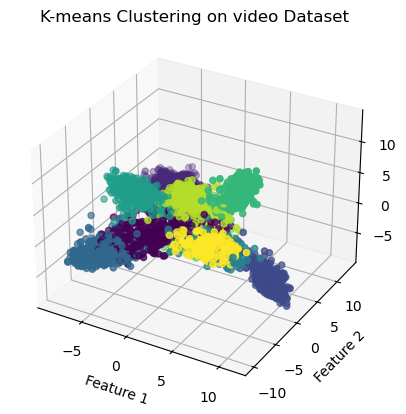

In [129]:
from matplotlib.animation import FuncAnimation
# Plot the data points and their cluster assignments
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
           marker='x', color='red', s=100 , linewidths=3)
# Set light blue background 

ax.set_title("K-means Clustering on video Dataset")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

# Función de animación
def update(frame):
    ax.view_init(elev=10, azim=frame)
    return fig,

# Crear animación
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=50, blit=True)

plt.show()